# A second attempt

My biggest Failure was my laziness to not actually map the objects to numerical values for anything, so that will be a large focus in this second attempt.  The other thing that I would like to do is account for outliers.

I will use some variables from the previous submission, which are loaded here.  Please see submission 1 if anything is confusing.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train_dataset = pd.read_csv('data/train.csv')
test_dataset = pd.read_csv('data/test.csv')

def compute_r(var, dependent_var=None): # default dependent_var is SalePrice in this project
    dependent_var = train_dataset['SalePrice'] if dependent_var is None else dependent_var
    var_mean = np.mean(var)
    dependent_var_mean = np.mean(dependent_var)
    var_variation = [x_i - var_mean for x_i in var]
    target_variation = [y_i - dependent_var_mean for y_i in dependent_var]
    
    r = (np.dot(var_variation, target_variation)) / (np.dot(var_variation, var_variation) * np.dot(target_variation, target_variation))**0.5

    return 0 if pd.isnull(r) else r

Something I missed doing before was really studying the SalePrice metric more

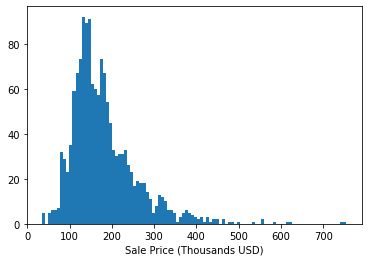

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [2]:
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100)
plt.xlabel('Sale Price (Thousands USD)')
plt.show()

train_dataset['SalePrice'].describe()

Let's write some code to check each permutation of all the non-numerical values, and figures the best R value of those permutations

In [3]:
def get_categories(column):
    value_dist = column.value_counts()
    outlier_threshold = 0.01 # 1% of recorded represented.  
    filt = value_dist > sum(value_dist) * outlier_threshold
    return list(value_dist[filt].index)


In [4]:
def get_map_function(column): # Strategy: get the average price per category, then list in that order
    column = pd.Series(column)
    
    map_values = get_categories(column)
    mapping_dictionary = {}
    
    for index, value in enumerate(column):
        if value in map_values:
            if value in mapping_dictionary:
                mapping_dictionary[value] = mapping_dictionary[value] + train_dataset['SalePrice'][index]
            elif not pd.isnull(value):
                mapping_dictionary[value] = train_dataset['SalePrice'][index]

    
    value_dist = column.value_counts()
    for key in mapping_dictionary:
        mapping_dictionary[key] = mapping_dictionary[key] / value_dist[key]
        
    mapping_dictionary = dict(sorted(mapping_dictionary.items(), key=lambda item: item[1]))
    
    zeros = -1
    for index, key in enumerate(mapping_dictionary):
        if mapping_dictionary[key] != 0:
            mapping_dictionary[key] = np.int64(index - zeros)
        else:
            zeros += 1
    # all values that are not in final dictionary converge to 0, so account for that in returned function
    return lambda x : mapping_dictionary[x] if not pd.isnull(x) and x in mapping_dictionary else 0

get_map_function(train_dataset['ExterCond'])(np.nan)

0

Now, we finally have a function that will take all non-numerical inputs, and creates a discrete integer map.  Now, we need to apply this method to each object column in our dataset, then we can analyze more R values.

In [24]:
mapped_train = pd.DataFrame(train_dataset).copy()
for column in mapped_train:
    if mapped_train[column].dtype == np.object:        
        mapped_train[column] = mapped_train[column].apply(get_map_function(mapped_train[column]))
    else:
        mapped_train[column] = mapped_train[column].apply(lambda x : x if not pd.isnull(x) else 0)
        
mapped_train.sample(frac=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
789,790,60,3,0.0,12205,1,0,2,3,1,...,0,0,0,0,0,7,2007,2,3,187500
1405,1406,120,1,44.0,3842,1,0,2,4,1,...,0,0,0,0,0,1,2008,2,3,275000
816,817,20,3,0.0,11425,1,0,2,2,1,...,0,0,0,0,0,7,2006,2,3,137000
464,465,20,3,60.0,8430,1,0,1,4,1,...,0,0,0,0,0,8,2009,2,3,124000
392,393,20,3,0.0,8339,1,0,2,2,1,...,0,0,3,2,1200,7,2007,2,3,106500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,1262,20,3,80.0,9600,1,0,1,2,1,...,0,0,0,0,0,6,2009,2,3,128900
660,661,60,3,0.0,12384,1,0,1,2,1,...,0,0,0,0,0,11,2007,2,3,197900
1309,1310,20,3,0.0,7153,1,0,1,2,1,...,0,0,2,0,0,6,2008,2,3,179200
969,970,190,3,75.0,10382,1,0,1,2,1,...,0,0,0,0,0,3,2006,0,3,140000


So now, we have every single data item, able to be expressed in a scatter plot, or have it's R statistic computed. Let's just appreciate this win by looking at one of the plots of a previously non-numerical value by sale price.

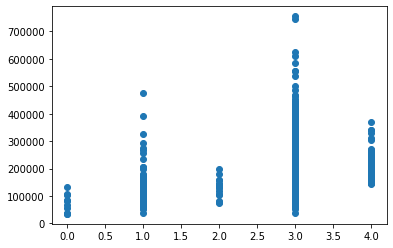

In [6]:
plt.scatter(mapped_train['MSZoning'], mapped_train['SalePrice'])
plt.show()

And, of course, we can simply compute R values with the following:

In [7]:
r_values = pd.Series([compute_r(mapped_train[value]) for value in mapped_train])
r_values.index = mapped_train.columns
filt = pd.isnull(r_values)
filt2 = abs(r_values) > 0.25
filt3 = r_values == 1
r_values = r_values[~filt][filt2][~filt3]
meaningful_values = list(r_values.index)
for index, value in enumerate(meaningful_values):
    print(f'{value}: \t {round(r_values[index], 2)}')

MSZoning: 	 0.32
LotArea: 	 0.26
LotShape: 	 0.26
Neighborhood: 	 0.67
HouseStyle: 	 0.26
OverallQual: 	 0.79
YearBuilt: 	 0.52
YearRemodAdd: 	 0.51
Exterior1st: 	 0.36
Exterior2nd: 	 0.34
MasVnrType: 	 0.4
ExterQual: 	 0.68
Foundation: 	 0.45
BsmtQual: 	 0.62
BsmtExposure: 	 0.37
BsmtFinType1: 	 0.38
BsmtFinSF1: 	 0.39
TotalBsmtSF: 	 0.61
HeatingQC: 	 0.43
CentralAir: 	 0.25
1stFlrSF: 	 0.61
2ndFlrSF: 	 0.32
GrLivArea: 	 0.71
FullBath: 	 0.56
HalfBath: 	 0.28
KitchenQual: 	 0.66
TotRmsAbvGrd: 	 0.53
Fireplaces: 	 0.47
FireplaceQu: 	 0.52
GarageType: 	 0.49
GarageFinish: 	 0.55
GarageCars: 	 0.64
GarageArea: 	 0.62
GarageQual: 	 0.27
GarageCond: 	 0.27
WoodDeckSF: 	 0.32
OpenPorchSF: 	 0.32
SaleType: 	 0.27
SaleCondition: 	 0.26


I know there's much more work to be done, but let's do a submission to see how far this improves our performance

In [8]:
meaningful_subset = mapped_train[meaningful_values]
meaningful_subset.head()



,MSZoning,LotArea,LotShape,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition
0,3,8450,1,15,5,7,2003,2003,9,9,...,3,2,2,548,2,2,0,61,2,3
1,3,9600,1,0,4,6,1976,1976,2,3,...,3,2,2,460,2,2,298,0,2,3
2,3,11250,2,15,5,7,2001,2002,9,9,...,3,2,2,608,2,2,0,42,2,3
3,3,9550,2,16,5,7,1915,1970,3,5,...,1,1,3,642,2,2,0,35,2,1
4,3,14260,2,22,5,8,2000,2000,9,9,...,3,2,3,836,2,2,192,84,2,3


Intercept: 
 107705.66511440865
Coefficients: 
 [ 1.36374154e+03  2.72578088e-01  5.24369613e+03  1.96370915e+03
  2.31312989e+02  1.24200951e+04 -1.25675245e+02  4.91081794e+00
  1.24038896e+03 -9.55488190e+02  2.31434335e+02  1.05840938e+04
  1.60583527e+02  6.38076010e+03  5.18968526e+03 -1.07903713e+03
  1.67677619e+01 -1.40697679e+00  1.24518191e+03  4.25570607e+03
  4.09190708e+01  2.67951307e+01  1.00277455e+01 -3.00407401e+03
  1.97834231e+03  1.11553228e+04  1.70255466e+03  2.54510773e+03
  1.03811605e+03  5.57254766e+02  7.43108631e+02  9.81929103e+03
  1.15305079e+01 -6.64385543e+03 -2.48477621e+03  2.06698241e+01
 -1.37707753e+00  3.94390102e+03  4.81020375e+03]


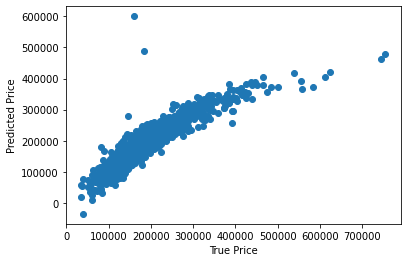

correlation of regression model prediction and trained model: 0.909670013864794


In [9]:
from sklearn import linear_model
from sklearn.metrics import log_loss
first_regr = linear_model.LinearRegression()
first_regr.fit(meaningful_subset, train_dataset['SalePrice'])
print('Intercept: \n', first_regr.intercept_)
print('Coefficients: \n', first_regr.coef_)

predicted_housing_prices = first_regr.predict(meaningful_subset)

plt.scatter(train_dataset['SalePrice'], predicted_housing_prices)
plt.ylabel('Predicted Price')
plt.xlabel('True Price')
plt.show()
print(f'correlation of regression model prediction and trained model: {compute_r(predicted_housing_prices)}')

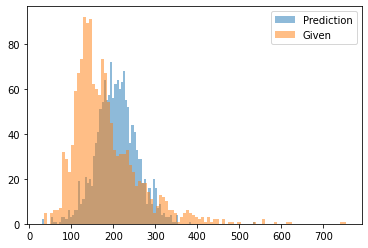

Note that the two distributions are representing different entities, predictions are of unknown values


In [10]:
test_dataset = pd.read_csv('data/test.csv')
ids = test_dataset['Id']

mapped_test = pd.DataFrame(test_dataset).copy()
for column in mapped_test:
    if mapped_test[column].dtype == np.object:        
        mapped_test[column] = mapped_test[column].apply(get_map_function(mapped_test[column]))
        
mapped_test = mapped_test[meaningful_values]
for column in mapped_test:
    for index, value in enumerate(mapped_test[column]):
        if pd.isnull(value):
            mapped_test[column][index] = 0

pred = pd.Series(first_regr.predict(mapped_test))
plt.hist([price/1000 for price in pred], bins=100, alpha=0.5, label='Prediction')
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100, alpha=0.5, label='Given')
plt.legend()
plt.show()

pd.DataFrame({"Id": ids, "SalePrice":pred}).to_csv('prediction_submission.csv', index=False)
print('Note that the two distributions are representing different entities, predictions are of unknown values')


In [11]:
pd.Series(np.subtract(train_dataset['SalePrice'], predicted_housing_prices)).describe()

count    1.460000e+03
mean     3.428670e-12
std      3.299499e+04
min     -4.404934e+05
25%     -1.679949e+04
50%     -7.829743e+02
75%      1.392585e+04
max      2.827746e+05
Name: SalePrice, dtype: float64

Well, after performing, we are now only in the bottom 11%!  Still not great, more to be done, but I feel good about the techniques that I am using! I understand a lot of the system that I am building, I know all the numbers that I am working with, and to me, that is important.  However, it's pretty clear.  I'm not giving up knowing that 89% of submissions did better than me.  (I always could just do a deep learning model, but where's the fun in that?)

Next steps: Replace Linear regression, remove outliers from train

Without looking up strategies of good methods to determine outliers, I will try an attempt to remove outliers from our mapped dataset, completely.

### My strategy for removing outliers

Take a column, for each value figure out the z-score significance of a value being within that distribution.  With a certain threshold (probably 3 std. dev) of rarity being removed from the dataset.

In [12]:
# remove_outliers(column: pd.Series): pd.Series # boolean (filter mask)
def remove_outliers_filter(column):
    z_score = lambda x : (x - np.mean(column))/np.std(column)
    z_score_dist = column.apply(z_score)
    filt = z_score_dist < 7
    return filt

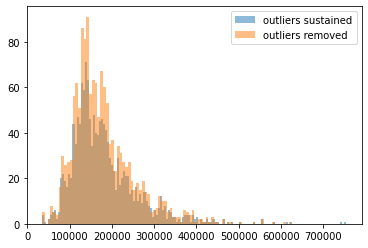

In [13]:
clean_data = mapped_train['SalePrice'].loc[remove_outliers_filter(mapped_train['SalePrice'])]

plt.hist(mapped_train['SalePrice'], bins=150, label='outliers sustained', alpha=0.5)
plt.hist(clean_data, bins=90, label='outliers removed', alpha=0.5)
plt.legend()
plt.show()

This is strange, that the histogram is showing different amplitdue of frequency, and I would like to figure out why it looks so drastic, but for now, after looking at the 5-number summary, I'm pretty confident that this all worked as intended, and it has something to do with the different counts and bin separations when plotting, not a failure in my outlier removal.

In [14]:
print(mapped_train['SalePrice'].describe())
print(clean_data.describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
count      1458.000000
mean     180140.566529
std       76645.846478
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      213875.000000
max      625000.000000
Name: SalePrice, dtype: float64


In [15]:
clean_data = pd.DataFrame(mapped_train).copy()

filt = pd.Series(np.ones((clean_data.shape[0]), dtype=bool))

for column in clean_data:
    filt = np.logical_and(remove_outliers_filter(clean_data[column]), filt)
    
clean_data = clean_data.loc[filt]
clean_data.describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.0,...,1091.0,1091.0,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000
mean,727.737855,56.205316,2.707608,69.806599,9807.790101,0.996334,0.099908,1.308891,2.052246,1.0,...,0.0,0.0,0.546288,0.057745,20.177819,6.347388,2007.800183,2.038497,2.937672,183518.404216
std,419.367931,42.157851,0.811459,21.543815,4994.460565,0.060467,0.392720,0.516608,0.455368,0.0,...,0.0,0.0,1.187246,0.333678,151.361168,2.675293,1.339738,0.451687,0.671683,78101.372051
min,1.000000,20.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,1.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,35311.000000
25%,372.500000,20.000000,3.000000,60.000000,7589.000000,1.000000,0.000000,1.000000,2.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,5.000000,2007.000000,2.000000,3.000000,130500.000000
50%,725.000000,50.000000,3.000000,70.000000,9350.000000,1.000000,0.000000,1.000000,2.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,6.000000,2008.000000,2.000000,3.000000,164000.000000
75%,1090.500000,70.000000,3.000000,80.000000,11309.000000,1.000000,0.000000,2.000000,2.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,8.000000,2009.000000,2.000000,3.000000,216018.500000
max,1460.000000,190.000000,4.000000,182.000000,70761.000000,1.000000,2.000000,3.000000,4.000000,1.0,...,0.0,0.0,4.000000,2.000000,2500.000000,12.000000,2010.000000,3.000000,4.000000,611657.000000


In [16]:
CLEAN_DATA_BACKUP = clean_data.copy()

In [17]:
clean_data = CLEAN_DATA_BACKUP.copy()

for column in clean_data:
    print(compute_r(clean_data[column], clean_data['SalePrice']))

-0.06311932267442036
-0.09515066782215587
0.34267439965655094
0.3495676287515031
0.37678768812711866
0.05835359273526745
-0.10971227303493798
0.31086944032796665
0.17220619106456678
0
0.10253566305402993
0.04707036982578164
0.6874893273802076
0.16078574072827798
0.029153452987173926
0.17715022109694498
0.2693663940446231
0.8077672553146974
-0.1407988699301334
0.5643245565289287
0.5527351598850119
0.24643109608532252
-0.039091305975730864
0.4246212088170305
0.4057330819511803
0.47615841891975297
0.48772145855017174
0.7251978197495226
0.1366995926754133
0.4866359389042471
0.6677045904235401
0.207826664001587
0.3894606770372898
0.42479739926637083
0.39687611370061365
0.15580619191007586
-0.05053583836009034
0.2338147874253203
0.6537783568681405
0.09570178683731825
0.46535743485386366
0.2270962882065234
0.23107885941565884
0.6243451508778449
0.2614896371211551
-0.05406878688408353
0.709475794560672
0.24285332905273013
-0.06711126195099372
0.5619991962472393
0.26462608224874623
0.1448102566

<ipython-input-1-ac284ad88175>:16: RuntimeWarning: invalid value encountered in double_scalars
  r = (np.dot(var_variation, target_variation)) / (np.dot(var_variation, var_variation) * np.dot(target_variation, target_variation))**0.5


In [18]:
r_values = pd.Series([compute_r(clean_data[value], clean_data['SalePrice']) for value in clean_data])
r_values.index = clean_data.columns
filt = pd.isnull(r_values)
filt2 = abs(r_values) > 0.25
filt3 = r_values == 1
r_values = r_values[~filt][filt2][~filt3]
meaningful_values = list(r_values.index)
for index, value in enumerate(meaningful_values):
    print(f'{value}: \t {round(r_values[index], 2)}')
    
meaningful_subset = clean_data[meaningful_values]



MSZoning: 	 0.34
LotFrontage: 	 0.35
LotArea: 	 0.38
LotShape: 	 0.31
Neighborhood: 	 0.69
HouseStyle: 	 0.27
OverallQual: 	 0.81
YearBuilt: 	 0.56
YearRemodAdd: 	 0.55
Exterior1st: 	 0.42
Exterior2nd: 	 0.41
MasVnrType: 	 0.48
MasVnrArea: 	 0.49
ExterQual: 	 0.73
Foundation: 	 0.49
BsmtQual: 	 0.67
BsmtExposure: 	 0.39
BsmtFinType1: 	 0.42
BsmtFinSF1: 	 0.4
TotalBsmtSF: 	 0.65
HeatingQC: 	 0.47
1stFlrSF: 	 0.62
2ndFlrSF: 	 0.26
GrLivArea: 	 0.71
FullBath: 	 0.56
HalfBath: 	 0.26
KitchenQual: 	 0.69
TotRmsAbvGrd: 	 0.55
Fireplaces: 	 0.45
FireplaceQu: 	 0.52
GarageType: 	 0.49
GarageYrBlt: 	 0.54
GarageFinish: 	 0.56
GarageCars: 	 0.66
GarageArea: 	 0.64
WoodDeckSF: 	 0.34
OpenPorchSF: 	 0.36
SaleType: 	 0.31
SaleCondition: 	 0.32


<ipython-input-1-ac284ad88175>:16: RuntimeWarning: invalid value encountered in double_scalars
  r = (np.dot(var_variation, target_variation)) / (np.dot(var_variation, var_variation) * np.dot(target_variation, target_variation))**0.5


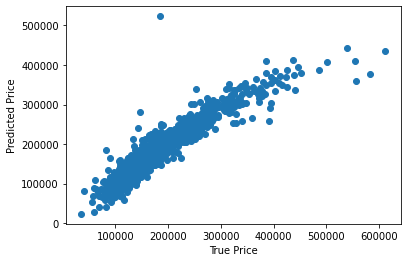

correlation of regression model prediction and trained model: 0.9303605050829366


In [19]:
second_regr = linear_model.LinearRegression()
second_regr.fit(meaningful_subset, clean_data['SalePrice'])

predicted_housing_prices = second_regr.predict(meaningful_subset)

plt.scatter(clean_data['SalePrice'], predicted_housing_prices)
plt.ylabel('Predicted Price')
plt.xlabel('True Price')
plt.show()
print(f'correlation of regression model prediction and trained model: {compute_r(predicted_housing_prices, clean_data["SalePrice"])}')

<ipython-input-20-11fec708d7a4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_test[column][index] = 0


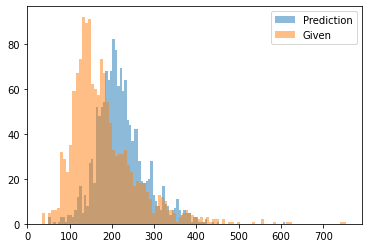

Note that the two distributions are representing different entities, predictions are of unknown values


In [20]:
test_dataset = pd.read_csv('data/test.csv')
ids = test_dataset['Id']

mapped_test = pd.DataFrame(test_dataset).copy()
for column in mapped_test:
    if mapped_test[column].dtype == np.object:        
        mapped_test[column] = mapped_test[column].apply(get_map_function(mapped_test[column]))
        
mapped_test = mapped_test[meaningful_values]
for column in mapped_test:
    for index, value in enumerate(mapped_test[column]):
        if pd.isnull(value):
            mapped_test[column][index] = 0

pred = pd.Series(second_regr.predict(mapped_test))
pred = pred.apply(lambda x : 50000 if x < 50000 else x)

plt.hist([price/1000 for price in pred], bins=100, alpha=0.5, label='Prediction')
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100, alpha=0.5, label='Given')
plt.legend()
plt.show()

pd.DataFrame({"Id": ids, "SalePrice":pred}).to_csv('prediction_submission.csv', index=False)
print('Note that the two distributions are representing different entities, predictions are of unknown values')



Wildly, this made my model worse than before.  Back to the drawing board! Or maybe, time to call it quits.  Next step, if I do pick this back up, is to refactor all of my code into classes, and start a new notebook

Note to self: make the sklearn model building process its own class, you're repeating a lot of code throughout these notebooks and it looks pretty bad